This notebook is to test the implementation of HSIC using finite-dimensional feature maps. FiniteFeatureHSIC class.

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

from fsic import (data, feature, kernel, util)
from fsic import indtest as it

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# font options
font = {
    #'family' : 'normal',
    #'weight' : 'bold',
    'size'   : 16
}

plt.rc('font', **font)
plt.rc('lines', linewidth=2)
#matplotlib.rc('text', usetex=True)
#matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

In [8]:
def get_quad_psfunc():
    """
    Return a PairedSource to generate y = x^2 + Gaussian noise.
    """
    px = lambda n: np.random.rand(n, 1)*8 - 4
    f = lambda x: 0.2*x**2 + np.random.randn(x.shape[0], 1)
    return data.PSFunc(f, px)
    

In [9]:
# paired source 
alpha = 0.05
n = 2000
seed = 18

dx = 10 
dy = 5
ps = data.PSIndSameGauss(dx, dy)
#ps = get_quad_psfunc()
#ps = data.PS2DUnifRotate(angle=np.pi/3)
#ps = data.PSIndUnif(xlb=[0, 3], xub=[1, 10], ylb=[-5, 5], yub=[8, 10])
#ps = data.PS2DSinFreq(freq=2)

pdata = ps.sample(n, seed=seed)
#tr, te = pdata.split_tr_te(tr_proportion=0.5, seed=10)

In [10]:
# get the median distances 
X, Y = pdata.xy()
medx = util.meddistance(X, subsample=1000)
medy = util.meddistance(Y, subsample=1000)
sigmax2 = medx**2
sigmay2 = medy**2

feature_pairs = 50
n_simulate = 5000
fmx = feature.RFFKGauss(sigmax2, n_features=feature_pairs, seed=seed+1)
fmy = feature.RFFKGauss(sigmay2, n_features=feature_pairs, seed=seed+2)
ffhsic = it.FiniteFeatureHSIC(fmx, fmy, n_simulate=n_simulate, alpha=alpha, seed=seed+89)
ffhsic_result = ffhsic.perform_test(pdata)
ffhsic_result


{'alpha': 0.05,
 'pvalue': 0.4904,
 'test_stat': 0.16380742150714425,
 'h0_rejected': False,
 'time_secs': 2.006108045578003,
 'n_simulate': 5000}

## Null distribution

Check that the distribution simulated from the spectral approach is the same as the one obtained by permutations.

In [11]:
n_permute = 500
n_simulate = 500

Zx = fmx.gen_features(X)
Zy = fmy.gen_features(Y)
list_perm = it.FiniteFeatureHSIC.list_permute(X, Y, fmx, fmy, n_permute=n_permute, seed=100)
list_spectral, eigx, eigy = it.FiniteFeatureHSIC.list_permute_spectral(Zx, Zy, 
                                                           n_simulate=n_simulate, seed=119)

In [12]:
freq_p, edge_p = np.histogram(list_perm)
freq_s, edge_s = np.histogram(list_spectral)
nfreq_p = freq_p/float(np.sum(freq_p))
nfreq_s = freq_s/float(np.sum(freq_s))
np.abs(nfreq_p-nfreq_s)


array([0.006, 0.018, 0.012, 0.01 , 0.022, 0.01 , 0.   , 0.01 , 0.008,
       0.004])

/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


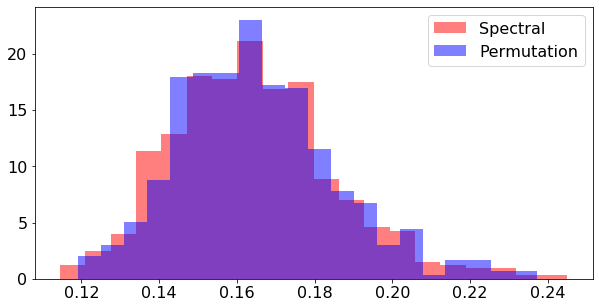

In [13]:
# histogram
plt.figure(figsize=(10, 5))
#plt.hist(list_perm, color='blue', alpha=0.7, normed=True, bins=20)
plt.hist(list_spectral, color='red', alpha=0.5, normed=True, bins=20, label='Spectral')
plt.hist(list_perm, color='blue', alpha=0.5, normed=True, bins=20, label='Permutation')
plt.legend()

## Eigen values

In [14]:
k = kernel.KGauss(sigmax2)
l = kernel.KGauss(sigmay2)
n = X.shape[0]
H = np.eye(n) - np.ones((n, n))/float(n)

K = k.eval(X, X)
L = l.eval(Y, Y)
HKH = H.dot(K).dot(H)
HLH = H.dot(L).dot(H)

In [15]:
full_eigx, _ = np.linalg.eig(HKH)
full_eigx = np.real(full_eigx)
full_eigy, _ = np.linalg.eig(HLH)
full_eigy = np.real(full_eigy)
# sort decreasingly
full_eigx = -np.sort(-full_eigx)/n
full_eigy = -np.sort(-full_eigy)/n

Text(0.5, 1.0, 'Product of eigenvalues')

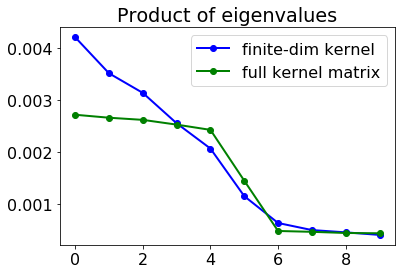

In [16]:
# compare the product of eigenvalues to the full kernel matrix case 
full_eig = np.outer(full_eigx, full_eigy).reshape(-1)
finite_eig = np.outer(eigx, eigy).reshape(-1)
lim = min(len(full_eig), len(finite_eig), 10)

plt.plot(finite_eig[:lim], 'bo-', label='finite-dim kernel')
plt.plot(full_eig[:lim], 'go-', label='full kernel matrix')
plt.legend()
plt.title('Product of eigenvalues')